## Bayesian Logistic Regression

In this notebook, we'll use Coin SVGD for a Bayesian logistic regression model.

We start by loading in the required modules.

In [1]:
import os
import time
from tqdm import tqdm

import scipy.io
from sklearn.model_selection import train_test_split
import numpy.matlib as nm
import numpy as np
import jax.numpy as jnp
from sgmcmcjax import ksd

from main import CoinSVGD

from plot_utils import *
from utils import *

And setting up some directories for saving plots & results.

In [2]:
# plots
plot_dir = "plots/SVGD/BayesianLR"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

ksd_vs_n_plot_dir = plot_dir
if not os.path.exists(ksd_vs_n_plot_dir):
    os.makedirs(ksd_vs_n_plot_dir)

# results
results_dir = "results/SVGD/BayesLR"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

ksd_vs_n_results_dir = results_dir
if not os.path.exists(ksd_vs_n_results_dir):
    os.makedirs(ksd_vs_n_results_dir)

### The Model

Now we're ready to define our model. We follow the setup in Liu and Wang (2016). 

In [3]:
class BayesianLR:
    """
    Bayesian Logistic Regression (see Liu et al. 2016, Gershman et al. 2012):
    Adapted from https://github.com/dilinwang820/Stein-Variational-Gradient-Descent/
    The observed data are D = {X, y}, where y_i in {-1,+1}, and X_i in R^d.
    The hidden data are theta = {w, alpha}, where w_j in R and alpha in R_+.
    The model is defined as follows:
        alpha ~ Gamma(alpha | a, b)
        w_j | alpha ~ N(w_j | 0, 1/alpha)
        y_i | x_i, w ~ Bernoulli(1+exp(-w^T x_t))
    """
    def __init__(self, X, Y, batchsize=200, a0=1, b0=0.01):
        self.X, self.Y = X, Y
        self.batchsize = min(batchsize, X.shape[0])
        self.a0, self.b0 = a0, b0

        self.N = X.shape[0]
        self.permutation = np.random.permutation(self.N)
        self.iter = 0

    def ln_prob(self, theta):

        if self.batchsize > 0:
            batch = [i % self.N for i in range(self.iter * self.batchsize, (self.iter + 1) * self.batchsize)]
            ridx = self.permutation[batch]
            self.iter += 1
        else:
            ridx = np.random.permutation(self.X.shape[0])

        Xs = self.X[ridx, :]
        Ys = self.Y[ridx]

        M, n = theta.shape[0], len(Ys)

        prob = np.zeros([n, M])
        for t in range(M):
            coff = np.multiply(Ys, np.sum(-1 * np.multiply(nm.repmat(theta[t, :], n, 1), Xs), axis=1))
            prob[:, t] = np.divide(np.ones(n), (1 + np.exp(coff)))

        prob = np.mean(prob, axis=1)
        llh = np.mean(np.log(prob))

        return llh

    def ln_prob_grad(self, theta):

        if self.batchsize > 0:
            batch = [i % self.N for i in range(self.iter * self.batchsize, (self.iter + 1) * self.batchsize)]
            ridx = self.permutation[batch]
            self.iter += 1
        else:
            ridx = np.random.permutation(self.X.shape[0])

        Xs = self.X[ridx, :]
        Ys = self.Y[ridx]

        w = theta[:, :-1]  # logistic weights
        alpha = np.exp(theta[:, -1])  # the last column is logalpha
        d = w.shape[1]

        wt = np.multiply((alpha / 2), np.sum(w ** 2, axis=1))

        coff = np.matmul(Xs, w.T)
        y_hat = 1.0 / (1.0 + np.exp(-1 * coff))

        dw_data = np.matmul(((nm.repmat(np.vstack(Ys), 1, theta.shape[0]) + 1) / 2.0 - y_hat).T, Xs)  # Y \in {-1,1}
        dw_prior = -np.multiply(nm.repmat(np.vstack(alpha), 1, d), w)
        dw = dw_data * 1.0 * self.X.shape[0] / Xs.shape[0] + dw_prior  # re-scale

        dalpha = d / 2.0 - wt + (self.a0 - 1) - self.b0 * alpha + 1  # the last term is the jacobian term

        return np.hstack([dw, np.vstack(dalpha)])  # % first order derivative
    
    @staticmethod
    def evaluation(theta, X_test, y_test):

        theta = theta[:, :-1]
        M, n_test = theta.shape[0], len(y_test)

        prob = np.zeros([n_test, M])
        for t in range(M):
            coff = np.multiply(y_test, np.sum(-1 * np.multiply(nm.repmat(theta[t, :], n_test, 1), X_test), axis=1))
            prob[:, t] = np.divide(np.ones(n_test), (1 + np.exp(coff)))

        prob = np.mean(prob, axis=1)
        acc = np.mean(prob > 0.5)
        llh = np.mean(np.log(prob))
        return [acc, llh]

### The Data

Next we'll load in the data. Here, we'll use the Covertype dataset.

In [5]:
# load data
data = scipy.io.loadmat('data/covertype.mat')

X_input = data['covtype'][:, 1:]
y_input = data['covtype'][:, 0]
y_input[y_input == 2] = -1

N = X_input.shape[0]
X_input = np.hstack([X_input, np.ones([N, 1])])
d = X_input.shape[1]
D = d + 1

### Experiment 1: Test Performance vs Learning Rate

We'll start with an experiment comparing the test performance (predictive accuracy and test log-likelihood) of Coin SVGD and SVGD, as we vary the learning rate for SVGD.

In [9]:
# iterations
n_iter = 5000

# hyper-parameters
a0, b0 = 1, 0.01

# number of particles
M = 50

# reps
n_reps = 2

# learning rates
steps = np.logspace(-5, 0, 10)
n_steps = len(steps)

all_final_theta = np.zeros((n_reps, n_steps, M, D))
all_ll = np.zeros((n_reps, n_steps))
all_acc = np.zeros((n_reps, n_steps))
all_final_theta_coin = np.zeros((n_reps, M, D))
all_ll_coin = np.zeros((n_reps))
all_acc_coin = np.zeros((n_reps))

for rep in range(n_reps):

    # print
    print("Rep: " + str(rep+1) + "/" + str(n_reps))

    # random seed
    np.random.seed(rep)

    # split the dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=rep)

    # model
    model = BayesianLR(X_train, y_train, batchsize=100, a0=a0, b0=b0)

    # initialisation
    theta0 = np.zeros([M, D]);
    alpha0 = np.random.gamma(a0, b0, M);
    for i in range(M):
        theta0[i, :] = np.hstack([np.random.normal(0, np.sqrt(1 / alpha0[i]), d), np.log(alpha0[i])])
    theta0 *= 0.1

    # SVGD
    thetas = list()
    for step in steps:
        theta = CoinSVGD().svgd_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad,
                                       n_iter=n_iter, stepsize=step, adagrad=True)
        thetas.append(theta)

    # coin SVGD
    theta_coin = CoinSVGD().coin_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad, n_iter=n_iter)

    # compute SVGD rmse and log-likelihood
    thetas_final = [t[-1] for t in thetas]
    outputs_svgd_final = [model.evaluation(t, X_test, y_test) for t in thetas_final]
    accs_svgd_final = [o[0] for o in outputs_svgd_final]
    lls_svgd_final = [o[1] for o in outputs_svgd_final]

    # compute coin SVGD rmse and log-likelihood
    theta_coin_final = theta_coin[-1]
    outputs_coin_final = model.evaluation(theta_coin_final, X_test, y_test)
    acc_coin_final = outputs_coin_final[0]
    lls_coin_final = outputs_coin_final[1]

    all_acc[rep, :] = accs_svgd_final
    all_ll[rep, :] = lls_svgd_final
    all_final_theta_coin[rep, :, :] = theta_coin_final
    all_acc_coin[rep] = acc_coin_final
    all_ll_coin[rep] = lls_coin_final

# save accuracy and ll vs step-size
np.save(results_dir + "/" + "lr_vs_acc_svgd", all_acc)
np.save(results_dir + "/" + "lr_vs_ll_svgd", all_ll)
np.save(results_dir + "/" + "lr_vs_acc_coin", all_acc_coin)
np.save(results_dir + "/" + "lr_vs_ll_coin", all_ll_coin)

# compute means and CIs
mean_acc = all_acc.mean(0)
mean_ll = all_ll.mean(0)
mean_acc_coin = all_acc_coin.mean()
mean_ll_coin = all_ll_coin.mean()

upper_acc, lower_acc = return_confidence_interval(all_acc)
upper_ll, lower_ll = return_confidence_interval(all_ll)
upper_acc_coin, lower_acc_coin = return_confidence_interval(all_acc_coin)
upper_ll_coin, lower_ll_coin = return_confidence_interval(all_ll_coin)

best_step_idx = np.argmax(mean_acc)
best_step = steps[best_step_idx]

np.save(results_dir + "/" + "best_step", best_step)

# plot accuracy vs step-size
plt.plot(stepsizes, mean_acc, ".-", label="SVGD", color="C0")
plt.fill_between(stepsizes, lower_acc, upper_acc, color="C0", alpha=0.1)
plt.grid(visible=True, color="whitesmoke", ls='-')
plt.axhline(mean_acc_coin, label="Coin SVGD", color="C1")
plt.fill_between(stepsizes, lower_acc_coin, upper_acc_coin, color="C1", alpha=0.1)
plt.xlabel("Learning Rate", fontsize=18)
plt.ylabel("Predictive Accuracy", fontsize=18)
plt.legend(prop={'size':18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.xscale("log")
fname = plot_dir + "/" + "lr_vs_acc.pdf"
plt.savefig(fname, format="pdf")
plt.show()

# plot ll vs step-size
plt.plot(stepsizes, -mean_ll, ".-", label="SVGD", color="C0")
plt.fill_between(stepsizes, -lower_ll, -upper_ll, color="C0", alpha=0.1)
plt.grid(visible=True, color="whitesmoke", ls='-')
plt.axhline(-mean_ll_coin, label='Coin SVGD', color="C1")
plt.fill_between(stepsizes, -lower_ll_coin, -upper_ll_coin, color="C1", alpha=0.1)
plt.xlabel("Learning Rate", fontsize=18)
plt.ylabel("Negative Log-Likelihood", fontsize=18)
plt.legend(prop={'size':18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15, left=0.18)
plt.xscale("log")
fname = plot_dir + "/" + "lr_vs_ll.pdf"
plt.savefig(fname, format="pdf")
plt.show()

Rep: 1/2
LR 1e-05
LR 4e-05
LR 0.00013
LR 0.00046
LR 0.00167
LR 0.00599
LR 0.02154
LR 0.07743
LR 0.27826
LR 1.0
Rep: 2/2
LR 1e-05
LR 4e-05
LR 0.00013
LR 0.00046
LR 0.00167
LR 0.00599
LR 0.02154
LR 0.07743
LR 0.27826
LR 1.0


### Experiment 2: Test Performance vs Iterations

Next we plot the test performance (predictive accuracy and test log-likelihood) against the iterations, for both SVGD and Coin SVGD. 

We'll look at three different learning rates for SVGD: the optimal learning rate (as determined by the results above), a smaller learning rate, and a bigger learning rate.

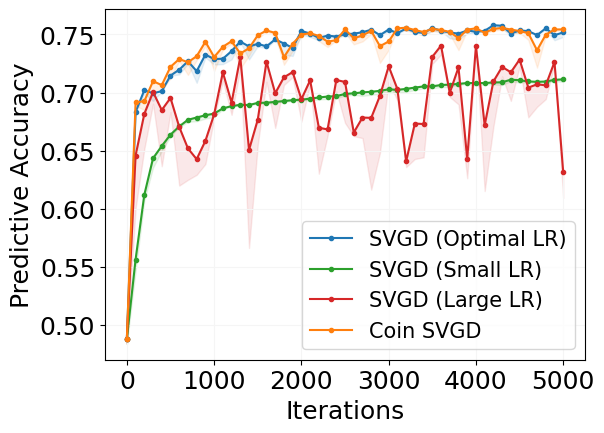

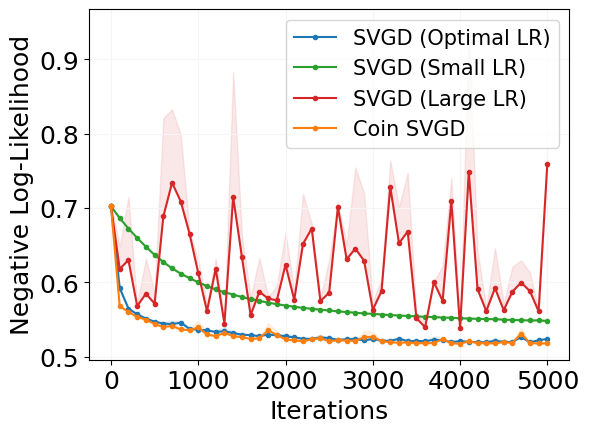

In [26]:
# iterations
iterations = np.arange(0, n_iter + 10, 100)

# learning rates
small_step = steps[best_step_idx - 2]
big_step = steps[best_step_idx + 2]

# reps
n_reps = 2

all_ll_best = np.zeros((n_reps, len(iterations)))
all_acc_best = np.zeros((n_reps, len(iterations)))
all_ll_small = np.zeros((n_reps, len(iterations)))
all_acc_small = np.zeros((n_reps, len(iterations)))
all_ll_big = np.zeros((n_reps, len(iterations)))
all_acc_big = np.zeros((n_reps, len(iterations)))
all_ll_coin = np.zeros((n_reps, len(iterations)))
all_acc_coin = np.zeros((n_reps, len(iterations)))

for rep in range(n_reps):

    # print progress
    print("Rep: " + str(rep + 1) + "/" + str(n_reps))

    # random seed
    np.random.seed(rep)

    # split the dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=rep)

    # model
    model = BayesianLR(X_train, y_train, batchsize=100, a0=a0, b0=b0)

    # initialisation
    theta0 = np.zeros([M, D]);
    alpha0 = np.random.gamma(a0, b0, M);
    for i in range(M):
        theta0[i, :] = np.hstack([np.random.normal(0, np.sqrt(1 / alpha0[i]), d), np.log(alpha0[i])])
    theta0*=0.1

    # SVGD
    print("Running SVGD (three LRs)...")
    theta = CoinSVGD().svgd_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad,
                                   n_iter=n_iter, stepsize=best_step, adagrad=True)
    theta_small = CoinSVGD().svgd_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad,
                                         n_iter=n_iter, stepsize=small_step, adagrad=True)
    theta_big = CoinSVGD().svgd_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad, 
                                       n_iter=n_iter, stepsize=big_step, adagrad=True)
    print("Evaluating SVGD...")
    outputs_best_svgd = [model.evaluation(theta[i], X_test, y_test) for i in iterations]
    acc_best_svgd, ll_best_svgd = [o[0] for o in outputs_best_svgd], [o[1] for o in outputs_best_svgd]##

    outputs_small_svgd = [model.evaluation(theta_small[i], X_test, y_test) for i in iterations]
    acc_small_svgd, ll_small_svgd = [o[0] for o in outputs_small_svgd], [o[1] for o in outputs_small_svgd]

    outputs_big_svgd = [model.evaluation(theta_big[i], X_test, y_test) for i in iterations]
    acc_big_svgd, ll_big_svgd = [o[0] for o in outputs_big_svgd], [o[1] for o in outputs_big_svgd]

    # coin SVGD
    print("Running Coin SVGD...")
    theta_coin = CoinSVGD().coin_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad,
                                          n_iter=n_iter, bandwidth=-1)
    print("Evaluating Coin SVGD...")
    outputs_coin = [model.evaluation(theta_coin[i], X_test, y_test) for i in iterations]
    acc_coin, ll_coin = [o[0] for o in outputs_coin], [o[1] for o in outputs_coin]

    # store results
    all_acc_best[rep, :] = acc_best_svgd
    all_ll_best[rep, :] = ll_best_svgd
    all_acc_small[rep, :] = acc_small_svgd
    all_ll_small[rep, :] = ll_small_svgd
    all_acc_big[rep, :] = acc_big_svgd
    all_ll_big[rep, :] = ll_big_svgd

    all_acc_coin[rep, :] = acc_coin
    all_ll_coin[rep, :] = ll_coin

# save results
np.save(results_dir + "/" + "iter_vs_acc_svgd_best", all_acc_best)
np.save(results_dir + "/" + "iter_vs_ll_svgd_best", all_ll_best)
np.save(results_dir + "/" + "iter_vs_acc_svgd_small", all_acc_small)
np.save(results_dir + "/" + "iter_vs_ll_svgd_small", all_ll_small)
np.save(results_dir + "/" + "iter_vs_acc_svgd_big", all_acc_big)
np.save(results_dir + "/" + "iter_vs_ll_svgd_big", all_ll_big)
np.save(results_dir + "/" + "iter_vs_acc_coin", all_acc_coin)
np.save(results_dir + "/" + "iter_vs_ll_coin", all_ll_coin)

# mean over reps
mean_acc_best = all_acc_best.mean(0)
mean_ll_best = all_ll_best.mean(0)
mean_acc_small = all_acc_small.mean(0)
mean_ll_small = all_ll_small.mean(0)
mean_acc_big = all_acc_big.mean(0)
mean_ll_big = all_ll_big.mean(0)
mean_acc_coin = all_acc_coin.mean(0)
mean_ll_coin = all_ll_coin.mean(0)

# boostrap CIs
lower_acc_best, upper_acc_best = return_confidence_interval(all_acc_best)
lower_ll_best, upper_ll_best = return_confidence_interval(all_ll_best)
lower_acc_small, upper_acc_small = return_confidence_interval(all_acc_small)
lower_ll_small, upper_ll_small = return_confidence_interval(all_ll_small)
lower_acc_big, upper_acc_big = return_confidence_interval(all_acc_big)
lower_ll_big, upper_ll_big = return_confidence_interval(all_ll_big)
lower_acc_coin, upper_acc_coin = return_confidence_interval(all_acc_coin)
lower_ll_coin, upper_ll_coin = return_confidence_interval(all_ll_coin)

# plot accuracy vs iterations
plt.plot(iterations, mean_acc_best, ".-", color="C0", label="SVGD (Optimal LR)")
plt.fill_between(iterations, lower_acc_best, upper_acc_best, color="C0", alpha=0.1)
plt.plot(iterations, mean_acc_small, ".-", color="C2", label="SVGD (Small LR)")
plt.fill_between(iterations, lower_acc_small, upper_acc_small, color="C2", alpha=0.1)
plt.plot(iterations, mean_acc_big, ".-", color="C3", label='SVGD (Large LR)')
plt.fill_between(iterations, lower_acc_big, upper_acc_big, color="C3", alpha=0.1)
plt.plot(iterations, mean_acc_coin, ".-", color="C1", label="Coin SVGD")
plt.fill_between(iterations, lower_acc_coin, upper_acc_coin, color="C1", alpha=0.1)
plt.grid(visible=True, color="whitesmoke", ls='-')
plt.legend(prop={'size': 15})
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Predictive Accuracy", fontsize=18)
plt.legend(prop={'size': 15})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
fname = plot_dir + "/" + "iter_vs_acc_svgd.pdf"
plt.savefig(fname, format="pdf", bbox_inches="tight")
plt.show()

# plot ll vs iterations
plt.plot(iterations, -mean_ll_best, ".-", color="C0", label="SVGD (Optimal LR)")
plt.fill_between(iterations, -lower_ll_best, -upper_ll_best, color="C0", alpha=0.1)
plt.plot(iterations, -mean_ll_small, ".-", color="C2", label="SVGD (Small LR)")
plt.fill_between(iterations, -lower_ll_small, -upper_ll_small, color="C2", alpha=0.1)
plt.plot(iterations, -mean_ll_big, ".-", color="C3", label='SVGD (Large LR)')
plt.fill_between(iterations, -lower_ll_big, -upper_ll_big, color="C3", alpha=0.1)
plt.plot(iterations, -mean_ll_coin, ".-", color="C1", label="Coin SVGD")
plt.fill_between(iterations, -lower_ll_coin, -upper_ll_coin, color="C1", alpha=0.1)
plt.grid(visible=True, color="whitesmoke", ls='-')
plt.legend(prop={'size': 15})
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("Negative Log-Likelihood", fontsize=18)
plt.legend(prop={'size': 15})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
fname = plot_dir + "/" + "iter_vs_ll_svgd.pdf"
plt.savefig(fname, format="pdf", bbox_inches="tight")
plt.show()

### Experiment 2: KSD vs Number of Particles (N)

Next we'll take a look at how the KSD varies as we change the number of particles. NB: this experiment will take some time!

In [ ]:
# model parameters
a0, b0 = 1, 0.01

# algorithm parameters
n_iter = 2500

# experiment parameters
M_vals = np.logspace(np.log10(5), np.log10(500), 20)
n_M_vals = len(M_vals)
  
# number of repeats
n_reps = 20

# array for KSD
svgd_ksd = np.zeros((n_M_vals, n_reps))
coin_svgd_ksd = np.zeros((n_M_vals, n_reps))

# array for time
svgd_times = np.zeros((n_M_vals, n_reps))
coin_svgd_times = np.zeros((n_M_vals, n_reps))

for ii, M in enumerate(M_vals):

    M = int(M)
    print(str(M) + " Particles")

    # random seed
    np.random.seed(ii)

    for jj in range(n_reps):

        print("Rep: " + str(jj+1) + "/" + str(n_reps))

        # split the dataset into training and testing
        X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=jj)

        # hyper-parameters
        a0, b0 = 1, 0.01

        # model
        model = BayesianLR(X_train, y_train, batchsize=100, a0=a0, b0=b0)
        model_for_KSD = BayesianLR(X_train, y_train, batchsize=X_train.shape[0], a0=a0, b0=b0)

        # repeat to get at least 500 samples for each configuration
        n_reps_inner = max(int(500/M), 5)

        print("Repeating SVGD and Coin SVGD to get at least 500 samples for computing the KSD...")

        svgd_ksd_tmp = np.zeros(n_reps_inner)
        coin_svgd_ksd_tmp = np.zeros(n_reps_inner)
        
        svgd_time_tmp = np.zeros(n_reps_inner)
        coin_svgd_time_tmp = np.zeros(n_reps_inner)

        for kk in range(n_reps_inner):

            # initialisation
            np.random.seed(kk)
            theta0 = np.zeros([M, D])
            alpha0 = np.random.gamma(a0, b0, M);
            for i in range(M):
                theta0[i, :] = np.hstack([np.random.normal(0, np.sqrt(1 / alpha0[i]), d), np.log(alpha0[i])])
            theta0 *= 0.1

            # SVGD
            start = time.time()
            theta = CoinSVGD().svgd_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad, n_iter=n_iter,
                                           stepsize=5e-2, adagrad=True)[-1]
            end = time.time()
            svgd_time = end - start
            svgd_time_tmp[kk] = svgd_time

            theta_grad = model_for_KSD.ln_prob_grad(theta)
            svgd_ksd_tmp[kk] = ksd.imq_KSD(jnp.asarray(theta), jnp.asarray(theta_grad))

            # coin SVGD
            start = time.time()
            theta_coin = CoinSVGD().coin_update(theta0=theta0.copy(), ln_prob_grad=model.ln_prob_grad, 
                                                n_iter=n_iter)[-1]
            end = time.time()
            coin_svgd_time = end - start
            coin_svgd_time_tmp[kk] = coin_svgd_time
            
            theta_coin_grad = model_for_KSD.ln_prob_grad(theta_coin)
            coin_svgd_ksd_tmp[kk] = ksd.imq_KSD(jnp.asarray(theta_coin), jnp.asarray(theta_coin_grad))
        
        svgd_ksd[ii,jj] = np.mean(svgd_ksd_tmp)
        coin_svgd_ksd[ii,jj] = np.mean(coin_svgd_ksd_tmp)
        
        svgd_times[ii,jj] = np.mean(svgd_time_tmp)
        coin_svgd_times[ii,jj] = np.mean(coin_svgd_time_tmp)
        
        print("The KSD for SVGD is " + str(svgd_ksd[ii,jj]))
        print("The KSD for Coin SVGD is " + str(coin_svgd_ksd[ii,jj]))


# save KSD results
np.save(ksd_vs_n_results_dir + "/" + "svgd_ksd_vs_n", svgd_ksd)
np.save(ksd_vs_n_results_dir + "/" + "coin_svgd_ksd_vs_n", coin_svgd_ksd)

# save time results
np.save(ksd_vs_n_results_dir + "/" + "svgd_time_vs_n", svgd_times)
np.save(ksd_vs_n_results_dir + "/" + "coin_svgd_time_vs_n", coin_svgd_times)

# ksd: means and CIs
svgd_ksd_mean = svgd_ksd.mean(1)
svgd_ksd_lower, svgd_ksd_upper = return_confidence_interval(svgd_ksd.T)
coin_svgd_ksd_mean = coin_svgd_ksd.mean(1)
coin_svgd_ksd_lower, coin_svgd_ksd_upper = return_confidence_interval(coin_svgd_ksd.T)

# plot KSD vs n
plt.close("all")
plt.plot(M_vals, np.log10(svgd_ksd_mean), ".-", label="SVGD (LR=5e-2)", color="C0")
plt.fill_between(M_vals, np.log10(svgd_ksd_lower), np.log10(svgd_ksd_upper), color="C0", alpha=0.1)
plt.plot(M_vals, np.log10(coin_svgd_ksd_mean), ".-", label="Coin SVGD", color="C1")
plt.fill_between(M_vals, np.log10(coin_svgd_ksd_lower), np.log10(coin_svgd_ksd_upper), color="C1", alpha=0.1)
plt.grid(visible=True, color="whitesmoke", ls='-')
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Log(KSD)", fontsize=14)
plt.legend(prop={'size': 14}, ncol=2, columnspacing=0.8)
plt.yticks(fontsize=14)
plt.ylim(top=4.7)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
plt.xscale("log")
plt.xticks(ticks=[5, 10, 20, 50, 100, 250, 500], labels=["5", "10", "20", "50", "100", "250", "500"], fontsize=15)
plt.show()
fname = ksd_vs_n_plot_dir + "/" + "ksd_vs_n.pdf"
plt.savefig(fname, format="pdf", bbox_inches="tight")
plt.show()

# time: means and CIs
svgd_times_mean = svgd_times.mean(1)
svgd_times_lower, svgd_times_upper = return_confidence_interval(svgd_times.T)
coin_svgd_times_mean = coin_svgd_times.mean(1)
coin_svgd_times_lower, coin_svgd_times_upper = return_confidence_interval(coin_svgd_times.T)

# plot time vs N
plt.close("all")
plt.plot(M_vals, svgd_times_mean, ".-", label="SVGD", color="C0")
plt.fill_between(M_vals, svgd_times_lower, svgd_times_upper, color="C0", alpha=0.1)
plt.plot(M_vals, coin_svgd_times_mean, ".-", label="Coin SVGD", color="C1")
plt.fill_between(M_vals, coin_svgd_times_lower, coin_svgd_times_upper, color="C1", alpha=0.1)
plt.grid(visible=True, color="whitesmoke", ls='-')
plt.xlabel("Number of Particles (N)", fontsize=14)
plt.ylabel("Clock Time (s)", fontsize=14)
plt.legend(prop={'size': 14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gcf().subplots_adjust(bottom=0.15, left=0.15)
fname = ksd_vs_n_plot_dir + "/" + "times_vs_n.pdf"
plt.savefig(fname, format="pdf", bbox_inches="tight")
plt.show()